In [2]:
import sys, os

# go up to the repo root (adjust "../.." if your notebook is nested deeper)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],  # or "Computer Modern Roman"
    'font.size': 8,
})

import shutil
shutil.which("latex")
import os
os.environ["PATH"] += os.pathsep + "/usr/texbin"  # or the actual path of MacTeX binaries


from experiment.plot_config import METHODS_CONFIG, METRICS_NAMING, DATA_TYPES_NAMING, DATA_TYPES_SHORT_NAMING
from definitions import DEFAULT_DATA_GEN_TYPES

MODEL_ASSUMPTIONS = {
    "Nonlinear Drift" : {
        "methods":["dcdi", "nodags", "kds-lnl_u_diag", "ours-lnl_u_diag"],
        "hatch": '//'
    },
    "Acyclic SCM" : {
        "methods":["gies", "igsp", "dcdi"],
        "color": 'white',
    },
    "Cyclic SCM" : {
        "methods":["llc", "nodags"],
        "color": 'tab:grey',
    },
    "Stationary Diffusion" : {
        "methods":["kds-linear_u_diag", "kds-lnl_u_diag", "ours-linear_u_diag", "ours-lnl_u_diag"],
        "color": 'tab:blue',
    },
}

# Paths
base_dir = os.path.join("..", "results")

# Which metrics to plot
metrics_to_plot = ["mse_test", "wasser_test"]

# Methods (map method names to display names)
METHODS_CONFIG = [m for m in METHODS_CONFIG if m[0] != '__true__'][::-1]
print(METHODS_CONFIG)
method_display = {m[0]: m[3] for m in METHODS_CONFIG if m[0] is not True}

# Collect data
all_data = {}
for data_type in DEFAULT_DATA_GEN_TYPES:
    csv_path = os.path.join(base_dir, f"{data_type}/summary_00_01_00/mean", f"df-{data_type}-summary_00_01_00.csv")
    df = pd.read_csv(csv_path)
    all_data[data_type] = df

def plot_metric_for_data_type(ax, df, metric, method_display, qlim_factor=2.0, short_label=False):
    """
    Plot horizontal boxplot for a single data_type & metric combination with model assumption styling.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis to draw on.
    df : pd.DataFrame
        The dataframe containing columns ['metric','method','val','data_idx'].
    metric : str
        The metric to filter on (e.g., 'mse_test').
    method_display : dict
        Dictionary mapping method keys to display names.
    qlim_factor : float
        Factor to multiply Q3 for x-axis limit.
    """
    import numpy as np
    
    # Map method to model assumption
    method_to_assumption = {}
    for assumption, props in MODEL_ASSUMPTIONS.items():
        for m in props["methods"]:
            if m not in method_to_assumption:
                method_to_assumption[m] = props.copy()  # start with a copy
            else:
                # merge new keys without overwriting existing ones
                for k, v in props.items():
                    if k not in method_to_assumption[m]:
                        method_to_assumption[m][k] = v


    # Filter dataframe for the current metric
    df_metric = df[df["metric"] == metric]

    # Remove datasets where any method has a NaN
    valid_data_idx = df_metric.groupby("data_idx")["val"].apply(lambda x: not x.isna().any())
    valid_indices = valid_data_idx[valid_data_idx].index
    df_metric_clean = df_metric[df_metric["data_idx"].isin(valid_indices)]

    # Extract values per method
    methods = list(method_display.keys())
    data = [df_metric_clean[df_metric_clean["method"] == m]["val"].values for m in methods]

    # Horizontal boxplot
    bp = ax.boxplot(
        data,
        tick_labels=[method_display[m] for m in methods],
        showfliers=False,
        vert=False,
        whis=1.5
    )
    
    # Make all median lines black
    for median_line in bp['medians']:
        median_line.set_color('black')
        median_line.set_linewidth(1.0)  # optional: thicker line



    # Stylize boxes according to model assumptions
    for i, m in enumerate(methods):
        props = method_to_assumption.get(m, {})
        color = props.get("color", "white")
        hatch = props.get("hatch", None)
        
        # Replace Line2D box with a Patch
        path = bp['boxes'][i].get_path()
        patch = PathPatch(path, facecolor=color, edgecolor='black', hatch=hatch, lw=1)
        ax.add_patch(patch)

    # Compute 75th percentile (Q3) for x-axis limit
    q3 = np.percentile(df_metric_clean["val"].dropna(), 75)
    ax.set_xlim([0, q3 * qlim_factor])

    # Title and grid
    if short_label:
        ax.set_title(f"{DATA_TYPES_SHORT_NAMING[data_type]}")
    else:
        ax.set_title(f"{METRICS_NAMING[metric]} for {DATA_TYPES_NAMING[data_type]}")
    ax.grid(True, axis='x', linestyle="--", alpha=0.7)


[('ours-lnl_u_diag', '#2b69ba', False, '\\textbf{SKDS (MLP)}'), ('ours-linear_u_diag', '#2b69ba', True, '\\textbf{SKDS (Linear)}'), ('kds-lnl_u_diag', 'darkgrey', False, 'KDS (MLP)'), ('kds-linear_u_diag', 'darkgrey', True, 'KDS (Linear)'), ('nodags', 'silver', False, 'NODAGS'), ('llc', 'silver', True, 'LLC'), ('dcdi', 'white', False, 'DCDI'), ('igsp', 'white', True, 'IGSP'), ('gies', 'white', True, 'GIES')]


In [3]:
import matplotlib.patches as mpatches
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.lines import Line2D

# Create legend elements dynamically
legend_elements = [Line2D([], [], linestyle='None', label='Model Assumptions')]
for name, props in MODEL_ASSUMPTIONS.items():
    hatch = props.get("hatch", None)
    color = props.get("color", "white")
    legend_elements.append(
        mpatches.Patch(facecolor=color, edgecolor='black', hatch=hatch, label=name)
    )

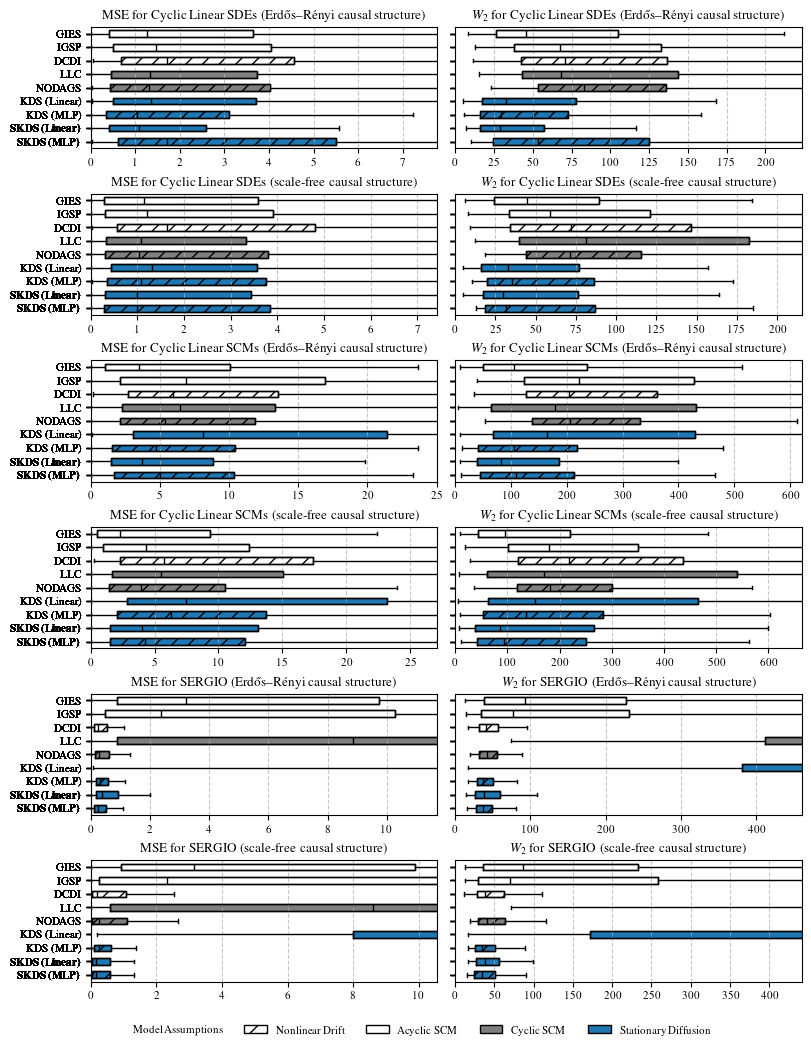

In [4]:
fig, axes = plt.subplots(len(DEFAULT_DATA_GEN_TYPES), len(metrics_to_plot),
                         figsize=(8, 10), sharey=True,
                         constrained_layout=True)

for i, data_type in enumerate(DEFAULT_DATA_GEN_TYPES):
    df = all_data[data_type]
    for j, metric in enumerate(metrics_to_plot):
        ax = axes[i, j]
        plot_metric_for_data_type(ax, df, metric, method_display, qlim_factor=2.0)# Add the custom legend

fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.01),  # position below the plot
    ncol=5,  # horizontal layout
    frameon=False
)
plt.savefig("Results-W2-Full.png", dpi=900, bbox_inches='tight')  # ensure legend is included
plt.show()

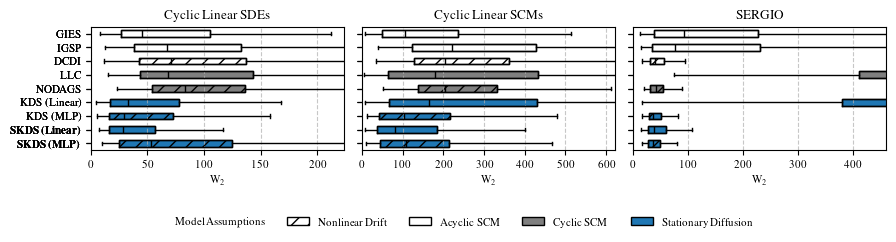

In [9]:
RESULTS_FIGURE_DATA_GEN_TYPES = [
    "linear-er",
    "scm-er",
    "sergio-er",
]

RESULTS_METRICS_TO_PLOT = ["wasser_test"]

fig, axes = plt.subplots(len(RESULTS_METRICS_TO_PLOT), len(RESULTS_FIGURE_DATA_GEN_TYPES), 
                         figsize=(9, 2), sharey=True)
for i, data_type in enumerate(RESULTS_FIGURE_DATA_GEN_TYPES):
    df = all_data[data_type]
    for j, metric in enumerate(RESULTS_METRICS_TO_PLOT):
        ax = axes[i] # , j]
        plot_metric_for_data_type(ax, df, metric, method_display, qlim_factor=2.0, short_label = True)
        ax.set_xlabel(r'$\mathrm{W}_2$')

fig.tight_layout()  # optional but helps spacing
fig.legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),  # slightly lower to avoid overlap
    ncol=5,
    frameon=False
)
plt.savefig("Results-W2-ER.png", dpi=900, bbox_inches='tight')  # ensure legend is included
plt.show()


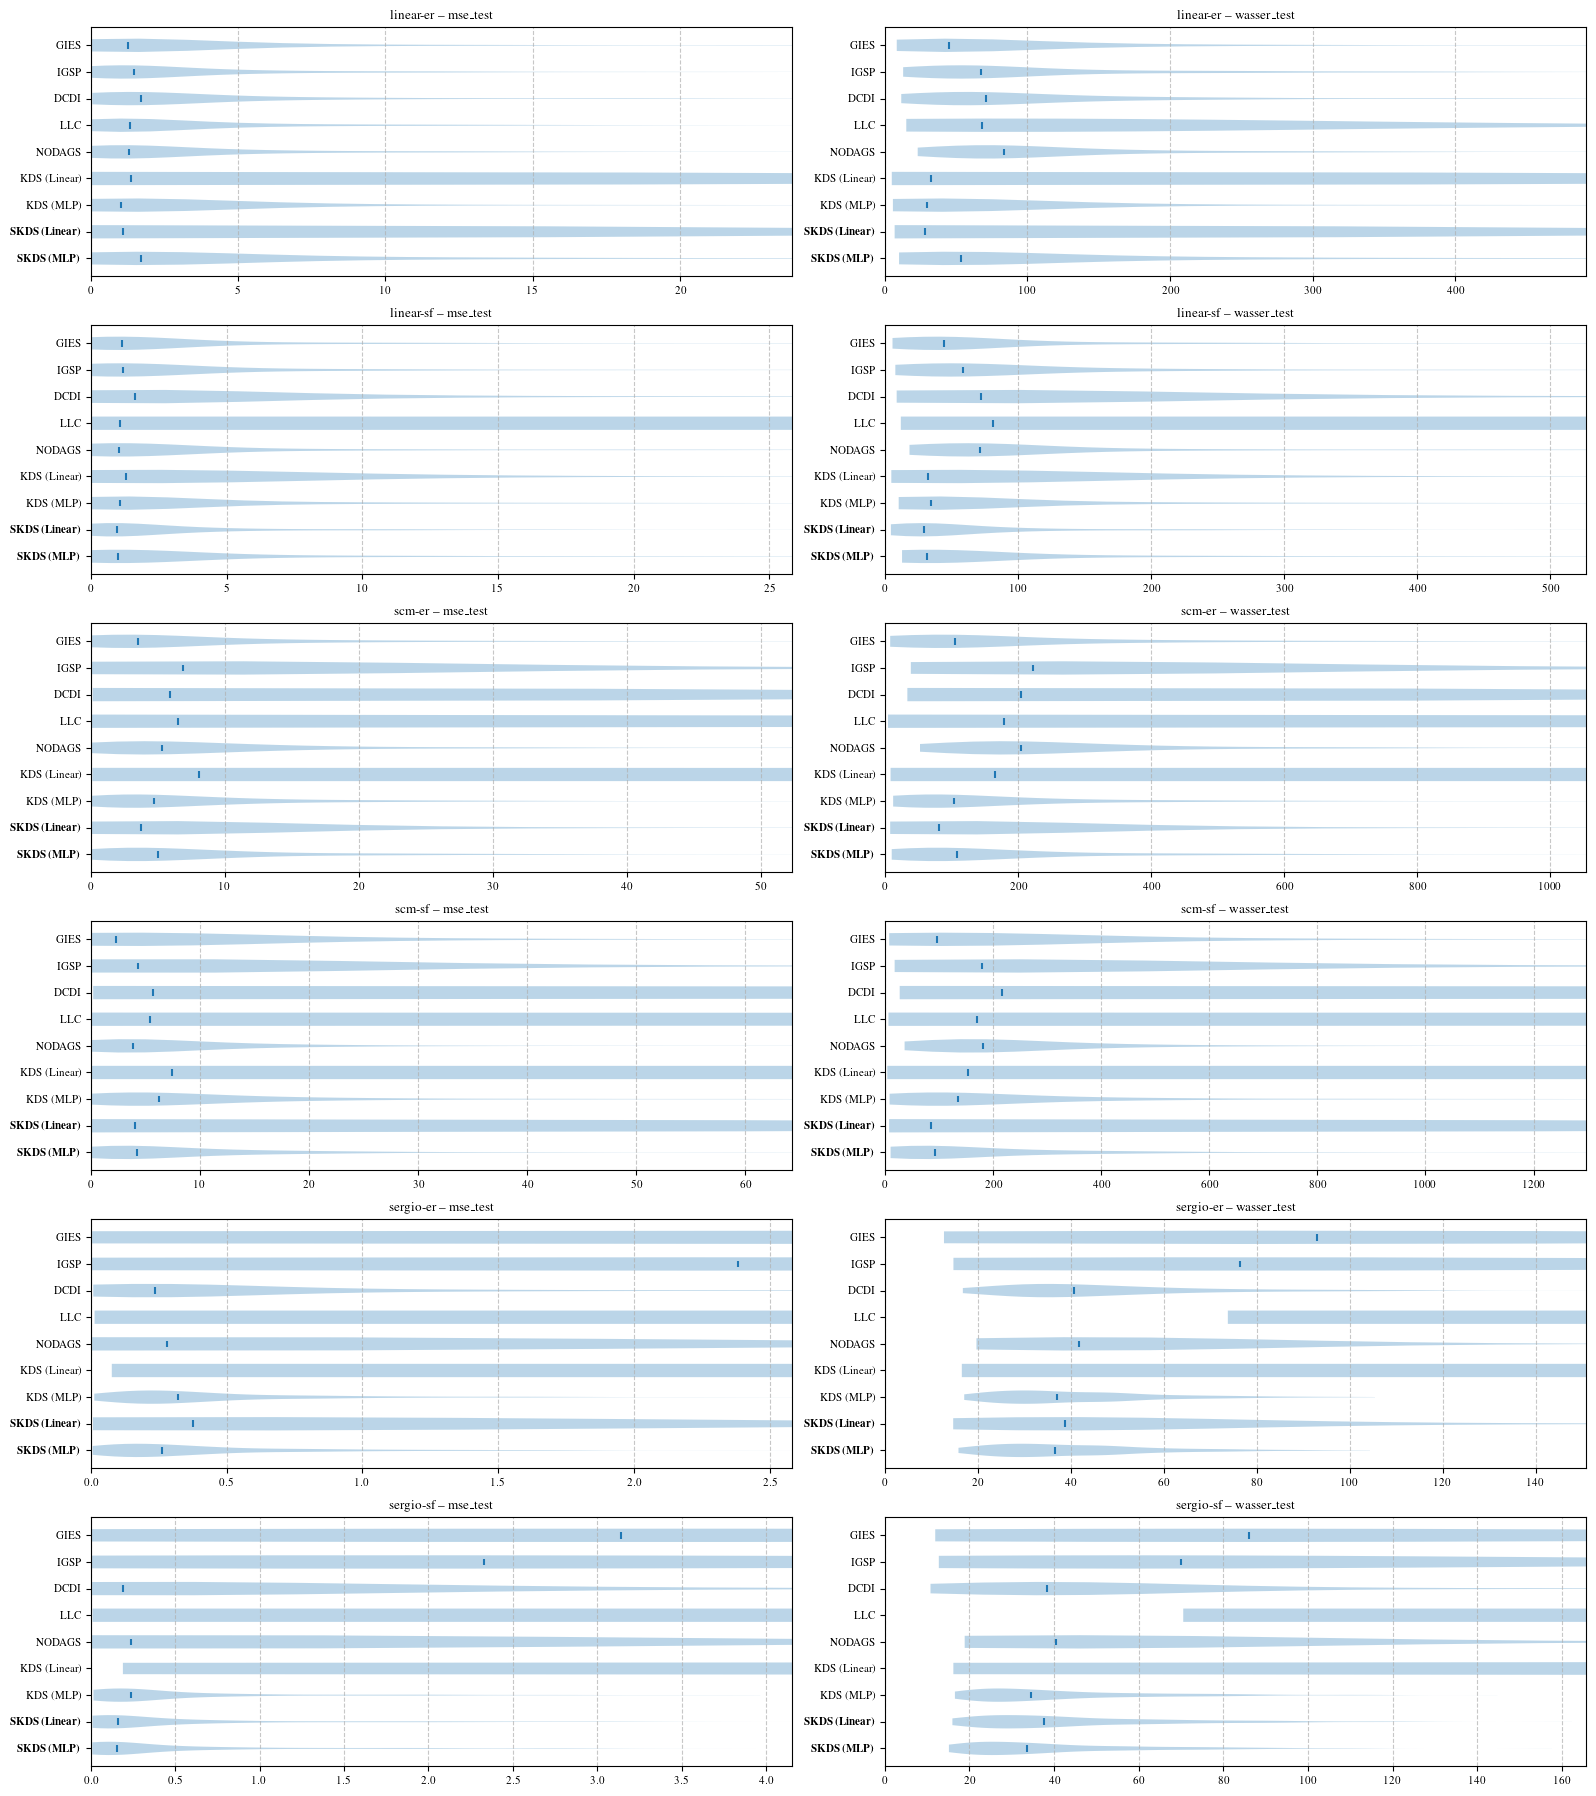

In [191]:
# Make violin plots
fig, axes = plt.subplots(len(DEFAULT_DATA_GEN_TYPES), len(metrics_to_plot), figsize=(16, 18), sharey="col")

for i, data_type in enumerate(DEFAULT_DATA_GEN_TYPES):
    df = all_data[data_type]
    for j, metric in enumerate(metrics_to_plot):
        ax = axes[i, j]

        df_metric = df[df["metric"] == metric]
        
        for m in method_display.keys():
            vals = df_metric[df_metric["method"] == m]["val"].values
            n_total = len(vals)
            n_nan = np.isnan(vals).sum()       # count of NaNs
            n_valid = n_total - n_nan          # count of non-NaN values
            # print(data_type, metric, m, "n_total:", n_total, "n_valid:", n_valid, "n_nan:", n_nan)

        
        # Remove datasets where any method has a NaN
        valid_data_idx = df_metric.groupby("data_idx")["val"].apply(lambda x: not x.isna().any())
        valid_indices = valid_data_idx[valid_data_idx].index  # indices of valid datasets
        
        # Filter df_metric to only valid datasets
        df_metric_clean = df_metric[df_metric["data_idx"].isin(valid_indices)]
        
        data = [
            vals if len(vals) > 0 else np.array([0.0, 50.0])
            for vals in [
                df_metric_clean[df_metric_clean["method"] == m]["val"].values
                for m in method_display.keys()
            ]
        ]

        q95_list = []
        for vals in data:
            vals = vals[~np.isnan(vals)]
            if len(vals) > 0:
                q95_list.append(np.percentile(vals, 95))
        
        if q95_list:
            x_max = min(q95_list) * 2  # small headroom beyond smallest Q3
            ax.set_xlim(0, x_max)
        
        parts = ax.violinplot(data, vert=False, showmedians=True, showextrema=False)
        ax.set_yticks(np.arange(1, len(data)+1))
        ax.set_yticklabels([method_display[m] for m in method_display.keys()])

        ax.set_title(f"{data_type} – {metric}")

        ax.grid(True, axis='x', linestyle="--", alpha=0.7)

fig.tight_layout()
plt.show()